In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [2]:
past_loans = pd.read_csv("data-Round1/PastLoans.csv")
#past_loans.drop(["digital1", "digital2"], axis=1, inplace=True)

In [3]:
past_loans.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,1,employed,1,33610,0.705613,0.068107,0.167038,0
1,1,employed,1,20650,0.000000,0.091152,0.000000,1
2,1,employed,1,8504,0.637625,0.000000,0.066207,0
3,1,employed,1,18460,0.276120,0.548380,0.625448,0
4,0,employed,0,8811,0.001974,0.500731,0.000000,1


In [4]:
past_loans['employment'].value_counts()

employed      58035
student       16259
unemployed    14152
retired       11554
Name: employment, dtype: int64

In [5]:
def preprocess(past_loans):
    # Make a deep copy to avoid modifying the original dataframe
    past_loans_copy = past_loans.copy()
    
    # Define income bins and labels
    income_bins = [-1, 5000, 20000, 50000, 1000000]
    income_labels = [0, 1, 2, 3]
    
    # Create a new column with income groups
    past_loans_copy['income_group'] = pd.cut(past_loans_copy['income'], bins=income_bins, labels=income_labels)
    
    # Convert 'income_group' to float type
    past_loans_copy['income_group'] = past_loans_copy['income_group'].astype(float)
    
    # One-hot encode the 'employment' column
    past_loans_copy = pd.get_dummies(past_loans_copy, columns=['employment'], drop_first=True)
    
    # Create an interaction term between 'income' and 'digital3'
    past_loans_copy['income_digital3'] = past_loans_copy['income'] * past_loans_copy['digital3']
    
    # Scale numeric features
    scaler = MinMaxScaler()
    numeric_features = ['income', 'digital3', 'income_digital3']
    past_loans_copy[numeric_features] = scaler.fit_transform(past_loans_copy[numeric_features])

    return past_loans_copy
past_loans_encoded = preprocess(past_loans)

In [6]:
past_loans_encoded['digital_avg'] = (past_loans_encoded['digital1'] + 
                                     past_loans_encoded['digital2'] + 
                                     past_loans_encoded['digital3']) / 3

w1,w2,w3= 0.25,0.25,0.5
    # Recalculate digital_weighted_avg using the given weights
past_loans_encoded['digital_weighted_avg'] = ((w1 * past_loans_encoded['digital1']) +
                                              (w2 * past_loans_encoded['digital2']) +
                                              (w3 * past_loans_encoded['digital3'])) / (w1 + w2 + w3)

past_loans_encoded.drop(['digital1','digital2','digital3','digital_avg'],inplace=True,axis=1)

In [7]:
past_loans_encoded.head()

,sex,married,income,default,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg
0,1,1,0.033610,0,2.0,0,0,0,0.005660,0.276949
1,1,1,0.020650,1,2.0,0,0,0,0.000000,0.022788
2,1,1,0.008504,0,1.0,0,0,0,0.000568,0.192510
3,1,1,0.018460,0,1.0,0,0,0,0.011639,0.518850
4,0,0,0.008811,1,1.0,0,0,0,0.000000,0.125676


# EDA

<AxesSubplot: >

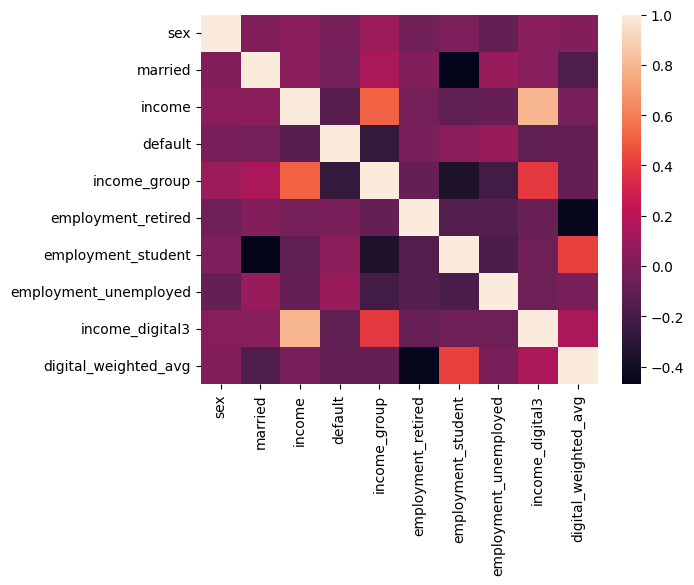

In [8]:
sns.heatmap(past_loans_encoded.corr())

In [9]:
Counter(past_loans_encoded["default"])

Counter({0: 77508, 1: 22492})

# Sampling

In [10]:
no_default = past_loans_encoded[past_loans_encoded["default"]==0]#[:22492]
default = past_loans_encoded[past_loans_encoded["default"]==1]
#add_to_test = past_loans_encoded[past_loans_encoded["default"]==0][22492:]``

df = pd.concat([no_default, default])
df

,sex,married,income,default,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg
0,1,1,0.033610,0,2.0,0,0,0,0.005660,0.276949
2,1,1,0.008504,0,1.0,0,0,0,0.000568,0.192510
3,1,1,0.018460,0,1.0,0,0,0,0.011639,0.518850
5,0,0,0.000000,0,0.0,0,1,0,0.000000,0.778440
8,0,0,0.009034,0,1.0,0,0,0,0.000000,0.343681
...,...,...,...,...,...,...,...,...,...,...
99986,1,1,0.008252,1,1.0,0,0,0,0.000000,0.116172
99990,0,1,0.004627,1,0.0,0,1,0,0.001559,0.403920
99993,0,1,0.015783,1,1.0,0,0,0,0.011096,0.549501
99995,0,1,0.024785,1,2.0,1,0,0,0.000000,0.051653


In [11]:
df.dtypes

sex                        int64
married                    int64
income                   float64
default                    int64
income_group             float64
employment_retired         uint8
employment_student         uint8
employment_unemployed      uint8
income_digital3          float64
digital_weighted_avg     float64
dtype: object

# Model

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the under-sampling method
under = RandomUnderSampler(sampling_strategy=0.5)  # This will reduce the majority class by half

# Define the over-sampling method
over = RandomOverSampler(sampling_strategy=0.75)  # This will increase the minority class to 75% of the majority class

# Define the pipeline that first applies under-sampling then over-sampling
pipeline = Pipeline(steps=[('u', under), ('o', over)])

# Apply the pipeline to our training data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

NameError: name 'X_train' is not defined

In [13]:
from sklearn.utils import resample
X = past_loans_encoded.drop("default", axis=1)
y = past_loans_encoded["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

def custom_average_sampling(X, y, under_ratio=0.5, over_ratio=0.75):
    # Split the dataset into the majority and minority class
    X_majority = X[y == 0]
    X_minority = X[y == 1]
    y_majority = y[y == 0]
    y_minority = y[y == 1]
    
    # Under-sample the majority class
    X_majority_under, y_majority_under = resample(X_majority, y_majority, 
                                                  replace=False, 
                                                  n_samples=int(len(X_minority) / over_ratio * under_ratio),
                                                  random_state=42)
    
    # Over-sample the minority class
    X_minority_over, y_minority_over = resample(X_minority, y_minority, 
                                                replace=True, 
                                                n_samples=int(len(X_majority_under) * over_ratio),
                                                random_state=42)
    
    # Combine the under-sampled majority class and over-sampled minority class
    X_resampled = pd.concat([X_majority_under, X_minority_over])
    y_resampled = pd.concat([y_majority_under, y_minority_over])
    
    return X_resampled, y_resampled

# Apply custom average sampling
X_resampled, y_resampled = custom_average_sampling(X_train, y_train)

# Check the distribution of the resampled dataset
y_resampled.value_counts()


0    11242
1     8431
Name: default, dtype: int64

In [14]:
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif

# Define a complex XGBoost classifier
model = XGBClassifier(
    tree_method="hist",
    device="cuda",
    eval_metric="auc",
    objective="binary:logistic",
    verbosity=1,
    max_depth=10,
    learning_rate=0.01,
    n_estimators=1000,
    gamma=2,
    subsample=0.8,
    colsample_bytree=0.8
)

# Fit the model on the resampled data
# Note: X_resampled and y_resampled should be created using the custom_average_sampling function provided earlier.
model.fit(X_resampled, y_resampled)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
#for i, l in zip(model.feature_importances_, model.feature_names_in_):
    #print(i, l)

# Test Data

In [15]:
results = model.predict(X_test)
probabilities = model.predict_proba(X_test).T[1]
X_test_predict = X_test.copy()
X_test_predict["default"] = y_test
X_test_predict["prediction"] = results
X_test_predict["probability"] = probabilities
X_test_predict[:50]

model.score(X_test, y_test)

c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [22:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.70168

In [16]:
from sklearn.metrics import auc,roc_curve
fpr, tpr, thresholds = roc_curve(y_test, results, pos_label = 1)
auc(fpr, tpr)

0.6683331007274473

In [17]:
f1_score(y_test, results)

0.4783885858161981

In [18]:
Counter(X_test_predict["prediction"])

Counter({0: 16330, 1: 8670})

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, results).ravel()
error_rate = fn/(fn+tn)
confusion_matrix(y_test, results)

array([[14122,  5250],
       [ 2208,  3420]], dtype=int64)

# Output

In [21]:
inference = pd.read_csv("data-Round1/NewApplications_Lender3.csv", index_col="id")
inference.head()
df_inference = preprocess(inference) 
df_inference['digital_weighted_avg'] = df_inference['digital3']
df_inference.drop('digital3',inplace=True,axis=1)

In [22]:
X_train.head()

,sex,married,income,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg
14444,1,1,0.021430,2.0,0,0,0,0.000000,0.207366
5031,1,0,0.008154,1.0,0,0,0,0.002846,0.347797
8217,0,1,0.011403,1.0,0,0,0,0.008036,0.412584
10260,1,1,0.007874,1.0,0,0,0,0.000323,0.144514
10573,1,1,0.184929,3.0,0,0,0,0.000000,0.152054


In [148]:
df_inference.head()

,sex,married,income,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg
id,,,,,,,,,
1,1,1,0.016514,1.0,0,0,1,0.000000,0.000000
2,0,1,0.008842,1.0,0,0,0,0.000000,0.000000
3,0,0,0.019424,1.0,0,0,0,0.012321,0.596777
4,1,1,0.007418,1.0,0,0,1,0.004907,0.622316
5,1,0,0.000843,0.0,1,0,0,0.000348,0.388934


In [149]:
inference_results = model.predict(df_inference)
inference_proba = model.predict_proba(df_inference).T[1]
df_results = df_inference.copy()
df_results["results"] = inference_results
df_results["prob"] = inference_proba
df_results

,sex,married,income,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg,results,prob
id,,,,,,,,,,,
1,1,1,0.016514,1.0,0,0,1,0.000000,0.000000,0,0.134521
2,0,1,0.008842,1.0,0,0,0,0.000000,0.000000,0,0.377892
3,0,0,0.019424,1.0,0,0,0,0.012321,0.596777,0,0.148067
4,1,1,0.007418,1.0,0,0,1,0.004907,0.622316,0,0.321109
5,1,0,0.000843,0.0,1,0,0,0.000348,0.388934,1,0.512896
...,...,...,...,...,...,...,...,...,...,...,...
99996,1,0,0.000000,0.0,0,1,0,0.000000,0.933294,0,0.413160
99997,1,1,0.018066,1.0,0,0,0,0.010905,0.567907,0,0.179653
99998,1,0,0.007273,1.0,0,0,0,0.005173,0.669182,0,0.479078


In [150]:
Counter(df_results["results"])

Counter({0: 69845, 1: 30155})

In [151]:
df_results["r"] = df_results["prob"]/(1-df_results["prob"])
df_results

,sex,married,income,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg,results,prob,r
id,,,,,,,,,,,,
1,1,1,0.016514,1.0,0,0,1,0.000000,0.000000,0,0.134521,0.155430
2,0,1,0.008842,1.0,0,0,0,0.000000,0.000000,0,0.377892,0.607439
3,0,0,0.019424,1.0,0,0,0,0.012321,0.596777,0,0.148067,0.173802
4,1,1,0.007418,1.0,0,0,1,0.004907,0.622316,0,0.321109,0.472991
5,1,0,0.000843,0.0,1,0,0,0.000348,0.388934,1,0.512896,1.052952
...,...,...,...,...,...,...,...,...,...,...,...,...
99996,1,0,0.000000,0.0,0,1,0,0.000000,0.933294,0,0.413160,0.704041
99997,1,1,0.018066,1.0,0,0,0,0.010905,0.567907,0,0.179653,0.218996
99998,1,0,0.007273,1.0,0,0,0,0.005173,0.669182,0,0.479078,0.919673


In [152]:
threshold = 0.5 # threshold of interest rates to keep

interest_rate_target = error_rate/(1-error_rate)
avg_r = np.mean(df_results[df_results["r"]<threshold]["r"])
increase = interest_rate_target - avg_r

markup = 0.1 # percentage over the interest rate to markup
df_results["final_r"] = (df_results["r"] + increase)#*(1 + markup)
df_results

# Put final_r to nan if r > threshold
df_results_del = df_results.copy()
df_results_del["final_r"] = df_results["final_r"].where(df_results["r"]<threshold, "")
df_results_del

,sex,married,income,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg,results,prob,r,final_r
id,,,,,,,,,,,,,
1,1,1,0.016514,1.0,0,0,1,0.000000,0.000000,0,0.134521,0.155430,0.105717
2,0,1,0.008842,1.0,0,0,0,0.000000,0.000000,0,0.377892,0.607439,
3,0,0,0.019424,1.0,0,0,0,0.012321,0.596777,0,0.148067,0.173802,0.124089
4,1,1,0.007418,1.0,0,0,1,0.004907,0.622316,0,0.321109,0.472991,0.423279
5,1,0,0.000843,0.0,1,0,0,0.000348,0.388934,1,0.512896,1.052952,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,1,0,0.000000,0.0,0,1,0,0.000000,0.933294,0,0.413160,0.704041,
99997,1,1,0.018066,1.0,0,0,0,0.010905,0.567907,0,0.179653,0.218996,0.169284
99998,1,0,0.007273,1.0,0,0,0,0.005173,0.669182,0,0.479078,0.919673,


In [153]:
# Actual Output dataframe
final = df_results_del[["final_r"]].reset_index()
final.rename(columns={"final_r" : "rate"}, inplace=True)

# Export

In [155]:
final.to_csv('output_1st_round.csv',index=False)